## Group Project 3

In [1]:
!pip install googlemaps


In [2]:
!pip install googlemaps networkx matplotlib

In [3]:
API_KEY = {api_key}

## The Map

In [4]:
import requests
from IPython.display import Image, display


# Draw the static Google map with nodes and paths
def display_map(points, edges, api_key):
    base_url = "https://maps.googleapis.com/maps/api/staticmap?size=800x600&maptype=roadmap"

    url = base_url

    # Add node markers
    for label, (lat, lon) in points.items():
        if label == "Brussels":  # Mark Paris as Start
            url += f"&markers=color:green%7Clabel:P%7C{lat},{lon}"
        elif label == "Rome":  # Mark Rome as Destination
            url += f"&markers=color:red%7Clabel:R%7C{lat},{lon}"
        else:
            url += f"&markers=color:blue%7Clabel:{label[0]}%7C{lat},{lon}"

    # Add paths (edges) between nodes
    for u, v in edges:
        lat1, lon1 = points[u]
        lat2, lon2 = points[v]
        url += f"&path=color:0x000000ff|weight:2|{lat1},{lon1}|{lat2},{lon2}"  # Draw blue paths

    # Attach the API key at the end
    url += f"&key={api_key}"

    # Fetch the map from Google and display it
    response = requests.get(url)
    display(Image(response.content))

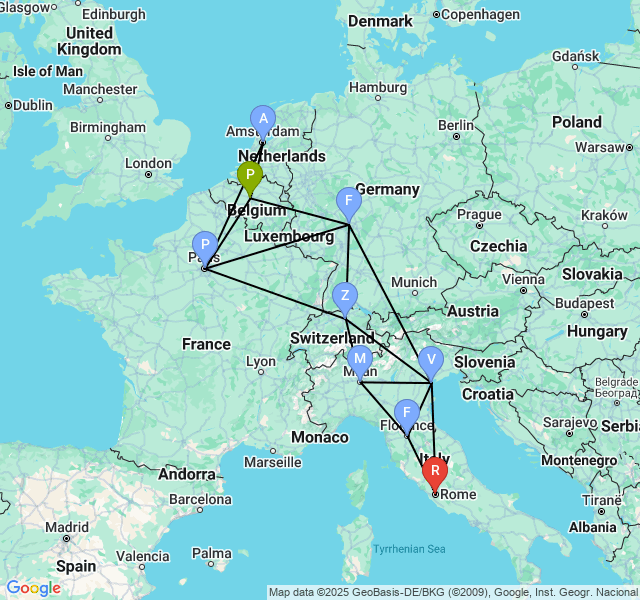

In [5]:
points = {
    'Brussels': [50.8503, 4.3517],  # START
    'Paris': [48.8566, 2.3522],     
    'Amsterdam': [52.3676, 4.9041],
    'Frankfurt': [50.1109, 8.6821],
    'Zurich': [47.3769, 8.5417],
    'Milan': [45.4642, 9.1900],
    'Venice': [45.4408, 12.3155],
    'Florence': [43.7696, 11.2558],
    'Rome': [41.9028, 12.4964]       # DESTINATION
}

edges = [
    ('Paris', 'Brussels'),
    ('Paris', 'Frankfurt'),
    ('Paris', 'Zurich'),
    ('Paris', 'Amsterdam'),
    ('Brussels', 'Amsterdam'),
    ('Brussels', 'Frankfurt'),
    ('Frankfurt', 'Zurich'),
    ('Frankfurt', 'Venice'),
    ('Zurich', 'Milan'),
    ('Zurich', 'Venice'),
    ('Milan', 'Venice'),
    ('Milan', 'Florence'),
    ('Venice', 'Florence'),
    ('Florence', 'Rome'),
    ('Venice', 'Rome')
]

start_location = "Brussels"
end_location="Rome"

# Display the Google Static Map
display_map(points, edges, API_KEY)

## Creating the Graph Data Struture where the Nodes are the Locatioons here cities and the Graph itself is the RoadMap

In [6]:
class Location:
    def __init__(self, name, coord):
        # Name of the location, czn be acity or a location on the map marked as "A"/ "B"/ ""
        self.name = name  
        # Tuple: Coordinate of the location
        self.coord = coord 
        # Dictionary: {Location object: travel_time}# A: [B, 1], [C, 2]
        self.neighbors = {}  

    def __str__(self):
        # List of (neighbor name, weight) pairs
        neighbors_list = [(neighbor.name if isinstance(neighbor, Location) else neighbor, weight) for neighbor, weight in self.neighbors.items()]
        return f"{self.name} : {neighbors_list}"

    def __repr__(self):
        return f"Location({self.name})"

In [7]:
class RoadMap:
    def __init__(self):
        # Dictionary {"<location name>": Location object}
        self.locations = {}  

    def add_location(self, name, coord):
        if name not in self.locations:
            self.locations[name] = Location(name, coord)

    def remove_location(self, name):
        if name in self.locations:
            location_to_remove = self.locations.pop(name)
            # Remove this node we just popped from the dictionary from all its neighbors' neighbor lists.
            # like if the structure is A : [('B', 6.1), ('C', 8.2)]; B : [('A', 6.1), ('C', 1.8)]; C : [('B', 1.8), ('A', 8.2)] and we remove A
            # then we alos remove A from its neighbours B and C , which is inside the neighbour list of B and C
            for neighbor in list(location_to_remove.neighbors.keys()):
                neighbor.neighbors.pop(location_to_remove, None)

    def add_road(self, start, end, travel_time):
        if start in self.locations and end in self.locations:
            from_location = self.locations[start]
            to_location = self.locations[end]
            # Add to_location as neighbor of from_location
            from_location.neighbors[to_location] = travel_time
            # Add from_location as neighbor of to_location (as its an undirected graph)
            to_location.neighbors[from_location] = travel_time  

    def remove_road(self, start, end):
        if start in self.locations and end in self.locations:
            from_location = self.locations[start]
            to_location = self.locations[end]
            # Remove to_location from from_location's neighbors
            from_location.neighbors.pop(end, None)
            # Remove from_location from to_location's neighbors
            to_location.neighbors.pop(start, None)

    def __str__(self):
        return "\n".join(str(location) for location in self.locations.values())


In [8]:
import googlemaps

def build_roadmap(points, edges, api_key):
    gmaps = googlemaps.Client(key=api_key)
    roadmap = RoadMap()

    for name, coord in points.items():
        roadmap.add_location(name, coord)

    print("Fetching travel times and building the roadmap")

    for u, v in edges:
        origin = points[u]
        destination = points[v]

        try:
            result = gmaps.distance_matrix(origins=[origin], destinations=[destination], mode="driving")
            time_min = result["rows"][0]["elements"][0]["duration"]["value"] / 60
            time_min = round(time_min, 1)

            roadmap.add_road(u, v, time_min)
            print(f"{u} → {v}: {time_min} min")

        except Exception as e:
            print(f"Error fetching {u} → {v}: {e}")

    return roadmap


In [9]:
# Print the RoadMap
roadmap_graph = build_roadmap(points, edges, API_KEY)

print(roadmap_graph)

Fetching travel times and building the roadmap
Paris → Brussels: 214.7 min
Paris → Frankfurt: 347.1 min
Paris → Zurich: 394.3 min
Paris → Amsterdam: 335.5 min
Brussels → Amsterdam: 153.3 min
Brussels → Frankfurt: 259.9 min
Frankfurt → Zurich: 264.2 min
Frankfurt → Venice: 574.8 min
Zurich → Milan: 206.6 min
Zurich → Venice: 344.8 min
Milan → Venice: 180.3 min
Milan → Florence: 213.6 min
Venice → Florence: 177.2 min
Florence → Rome: 185.8 min
Venice → Rome: 330.0 min
Paris : [('Brussels', 214.7), ('Frankfurt', 347.1), ('Zurich', 394.3), ('Amsterdam', 335.5)]
Brussels : [('Paris', 214.7), ('Amsterdam', 153.3), ('Frankfurt', 259.9)]
Amsterdam : [('Paris', 335.5), ('Brussels', 153.3)]
Frankfurt : [('Paris', 347.1), ('Brussels', 259.9), ('Zurich', 264.2), ('Venice', 574.8)]
Zurich : [('Paris', 394.3), ('Frankfurt', 264.2), ('Milan', 206.6), ('Venice', 344.8)]
Milan : [('Zurich', 206.6), ('Venice', 180.3), ('Florence', 213.6)]
Venice : [('Frankfurt', 574.8), ('Zurich', 344.8), ('Milan', 180.

## Plotting the Graph

In [ ]:
import matplotlib.pyplot as plt

def plot_graph_on_map(graph, start_name, end_name, path=None):
    plt.figure(figsize=(10, 8))

    # Step 1: Draw all edges first
    for from_loc in graph.locations.values():
        for to_loc, weight in from_loc.neighbors.items():
            if from_loc.name < to_loc.name:
                x_coords = [from_loc.coord[1], to_loc.coord[1]]  # longitudes
                y_coords = [from_loc.coord[0], to_loc.coord[0]]  # latitudes

                # Check if this edge is part of the shortest path
                if path is not None:
                    path_edges = set((path[i], path[i+1]) for i in range(len(path)-1))
                    reverse_path_edges = set((path[i+1], path[i]) for i in range(len(path)-1))
                    if (from_loc.name, to_loc.name) in path_edges or (from_loc.name, to_loc.name) in reverse_path_edges:
                        plt.plot(x_coords, y_coords, 'limegreen', linewidth=4, zorder=2)  # Highlighted path
                    else:
                        plt.plot(x_coords, y_coords, 'k-', linewidth=1)
                else:
                    plt.plot(x_coords, y_coords, 'k-', linewidth=1)

                # Place weight label (travel time) at midpoint
                mid_x = (x_coords[0] + x_coords[1]) / 2
                mid_y = (y_coords[0] + y_coords[1]) / 2
                plt.text(mid_x + 0.002, mid_y + 0.002, f"{weight}", fontsize=9, ha='center', color='black')

    # Step 2: Draw all nodes
    for name, location in graph.locations.items():
        lon, lat = location.coord[1], location.coord[0]

        if name == start_name:
            color = "lightgreen"  # Start node
        elif name == end_name:
            color = "red"          # End node
        else:
            color = "lightblue"    # Regular nodes

        plt.scatter(lon, lat, color=color, s=300, edgecolors='black', zorder=3)
        plt.text(lon, lat + 0.001, name, ha='center', va='bottom', fontsize=12, weight='bold')

    # Final clean-up
    plt.title("City Roadmap with Travel Times", pad=20)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


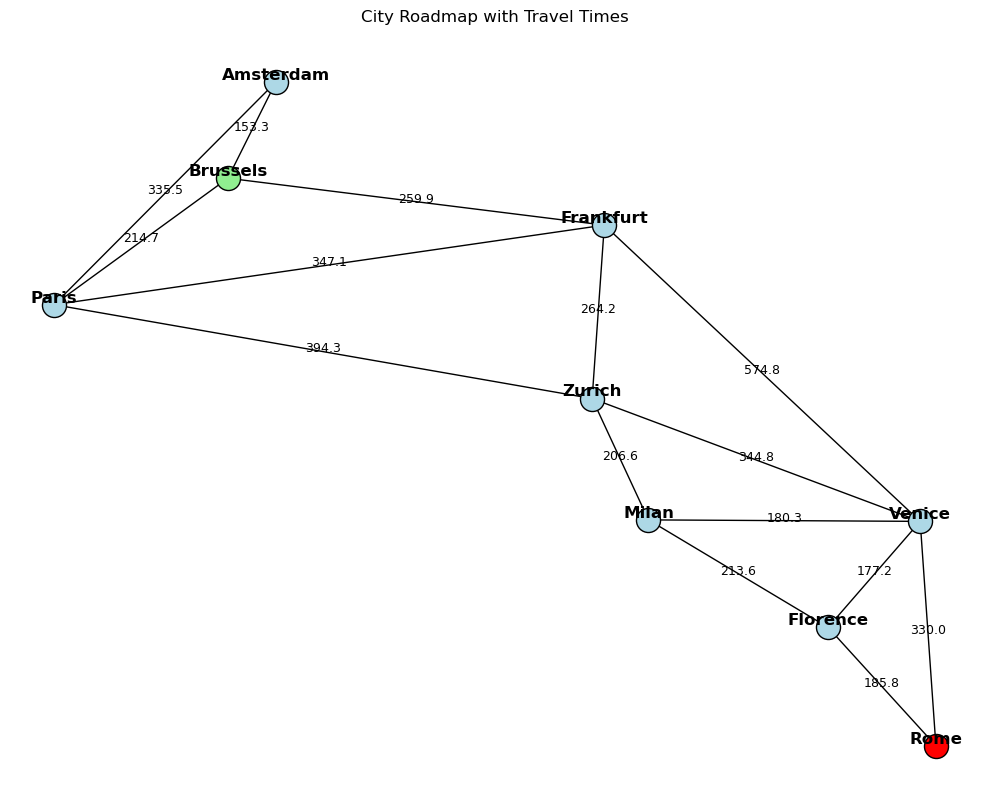

In [ ]:
plot_graph_on_map(roadmap_graph, start_location, end_location)


## 1. Base Case

### Implementing Dijktra's Algorithm to find the shortest path

In [ ]:
import heapq  

def find_shortest_path(roadmap, start_name, end_name=None):
    # Initialize a dictionary to store cost and full path (pred) for each location
    location_data = {name: {'cost': float('inf'), 'pred': []} for name in roadmap.locations}
    
    # Cost to reach start location is zero
    location_data[start_name]['cost'] = 0 
    
    # Start location has no predecessor initially
    location_data[start_name]['pred'] = [] 

    # Set to keep track of visited locations
    visited = set() 

    # Initialize the min-heap with (cost, location_name) starting from the source
    min_heap = [(0, start_name)]

    while min_heap:
        # Pop the location with the smallest cost from the heap
        current_cost, current_location = heapq.heappop(min_heap)

        # If location is already visited then skip
        if current_location in visited:
            continue

        # Mark the location as visited
        visited.add(current_location)

        # If we have reached the destination, stop early
        if end_name is not None and current_location == end_name:
            break

        # Visit each neighbor of the current location
        for neighbor_location, weight in roadmap.locations[current_location].neighbors.items():
            neighbor_name = neighbor_location.name

            if neighbor_name not in visited:
                new_cost = current_cost + weight  # Calculate the cost to reach the neighbor

                # If this cost is lesser than previous cost, update neighbor's cost and path
                if new_cost < location_data[neighbor_name]['cost']:
                    location_data[neighbor_name]['cost'] = new_cost
                    location_data[neighbor_name]['pred'] = location_data[current_location]['pred'] + [current_location]

                    # Push updated neighbor into the heap
                    heapq.heappush(min_heap, (new_cost, neighbor_name))

    # Making sure to add the end location in the shortest path 
    if end_name is not None:
        shortest_path = location_data[end_name]['pred'] + [end_name]
        return location_data, shortest_path
    else:
        return location_data, None


### Visualizing the Shortest Path

Shortest Path: ['Brussels', 'Frankfurt', 'Zurich', 'Milan', 'Florence', 'Rome']
Total Cost: 1130.1


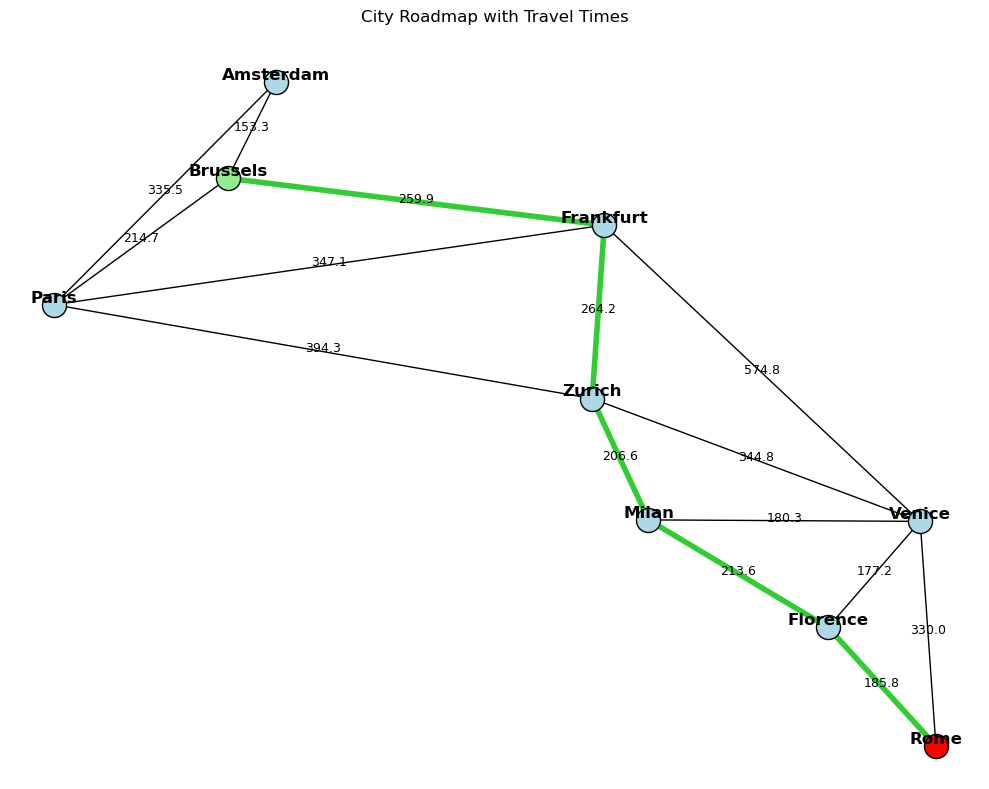

In [ ]:
# Find shortest path
location_data, shortest_path = find_shortest_path(roadmap_graph, start_location, end_location)

print("Shortest Path:", shortest_path)
print("Total Cost:", location_data[end_location]["cost"])


# Plot the graph and highlight the shortest path
plot_graph_on_map(roadmap_graph, start_location, end_location, path=shortest_path)


### 2. Rush Hour Scenario

In [ ]:
import random
import copy

# Function to simulate rush hour conditions by modifying edge weights
def simulate_rush_hour(roadmap):
    # Create a deep copy of the roadmap to avoid altering the original
    rush_roadmap = copy.deepcopy(roadmap)
    
    # Dictionary to store scaling factor applied to each edge
    factor_dict = {}

    # Loop over each location in the copied roadmap
    for location in rush_roadmap.locations.values():
        for neighbor_location in location.neighbors:
            # Avoid double-counting undirected edges
            if location.name < neighbor_location.name:  
                # Generate random scaling factor
                factor = min(max(random.normalvariate(2, 0.5), 1), 3)

                # Get the original weight
                original_weight = location.neighbors[neighbor_location]

                # Update the neighbor's weight
                new_weight = round(original_weight * factor, 1)
                location.neighbors[neighbor_location] = new_weight
                neighbor_location.neighbors[location] = new_weight  # Update both directions

                # Save the factor applied
                factor_dict[(location.name, neighbor_location.name)] = factor

    # Return both the modified roadmap and the factor dictionary
    return rush_roadmap, factor_dict

The factor by which the time was increased was :
{('Paris', 'Zurich'): 1.6313080052905098, ('Brussels', 'Paris'): 1.9478804627016324, ('Brussels', 'Frankfurt'): 2.5732862444895206, ('Amsterdam', 'Paris'): 2.133265404558979, ('Amsterdam', 'Brussels'): 2.1150802265456448, ('Frankfurt', 'Paris'): 2.4144720661088903, ('Frankfurt', 'Zurich'): 1.5572004939485535, ('Frankfurt', 'Venice'): 2.4910462498283543, ('Milan', 'Zurich'): 2.2616609489156287, ('Milan', 'Venice'): 2.1179682844621293, ('Venice', 'Zurich'): 2.496600338878305, ('Florence', 'Milan'): 2.0247882893679594, ('Florence', 'Venice'): 2.14017552598804, ('Florence', 'Rome'): 2.7722045620882345, ('Rome', 'Venice'): 2.30747145388443}


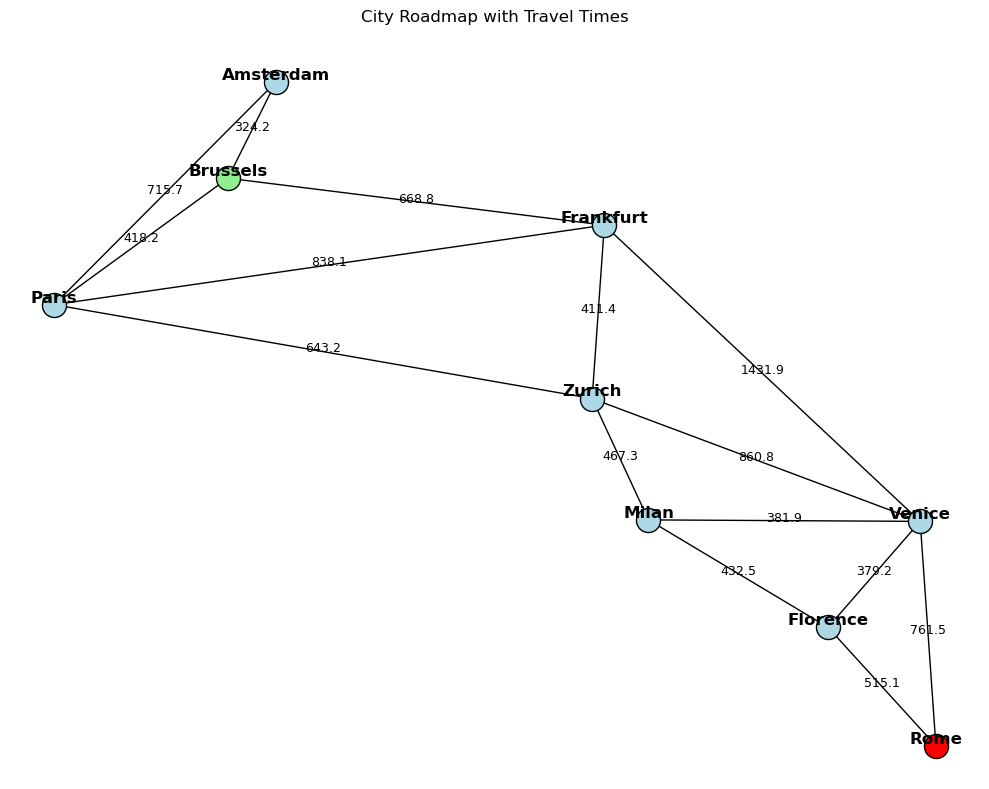

In [ ]:
# Simulate rush hour
rush_roadmap_graph, factor_dict = simulate_rush_hour(roadmap_graph)

print("The factor by which the time was increased was :")

print(factor_dict) 
plot_graph_on_map(rush_roadmap_graph, start_location, end_location)

Shortest Path: ['Brussels', 'Paris', 'Zurich', 'Milan', 'Florence', 'Rome']
Total Cost: 0


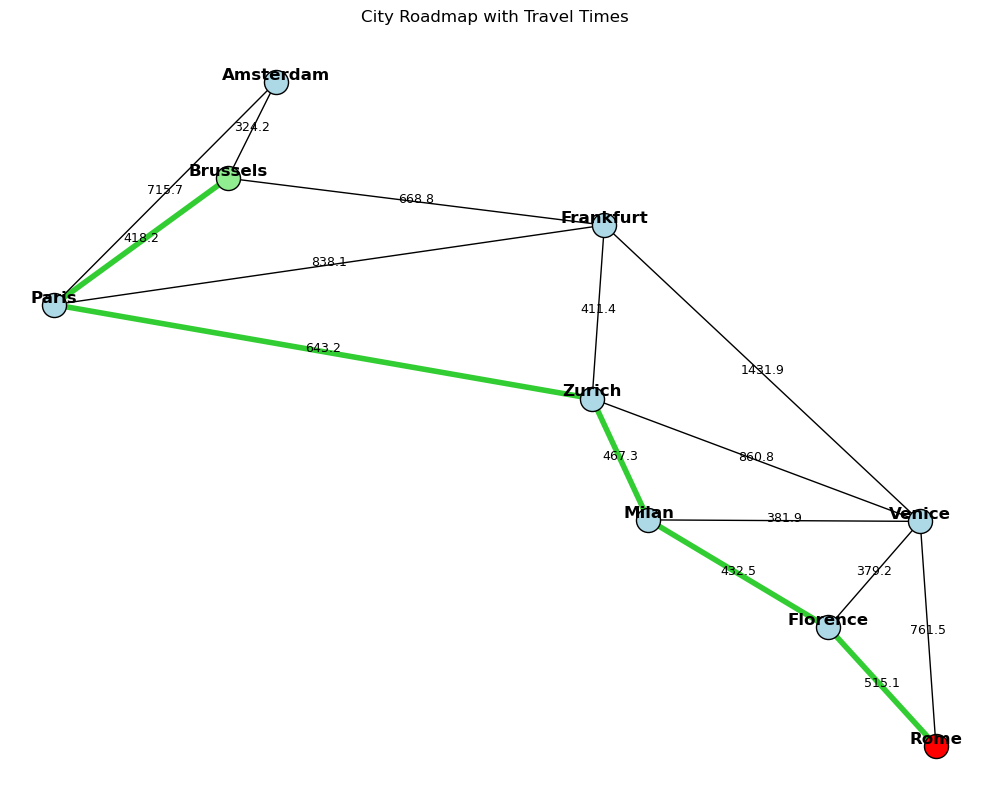

In [ ]:
# Find shortest path
rush_road_location_data, rush_hours_shortest_path = find_shortest_path(rush_roadmap_graph, start_location, end_location)

print("Shortest Path:", rush_hours_shortest_path)
print("Total Cost:", rush_road_location_data[start_location]["cost"])


# Plot the graph and highlight the shortest path
plot_graph_on_map(rush_roadmap_graph, start_location, end_location, path=rush_hours_shortest_path)

### 3. Simulating Base case and Rush Hour with Additional Rare Uncertainty Events

In [ ]:
import random

# Function to simulate rush hour conditions with optional uncertainty
def simulate_for_uncertainty(roadmap, rush_hour=False):
    # Decide if we simulate rush hour or just use the base roadmap
    if rush_hour:
        # Apply rush hour effect: weights inflated randomly
        rush_roadmap, factor_dict = simulate_rush_hour(roadmap)
        uncertain_roadmap = rush_roadmap
    else:
        # Base case: use normal roadmap without modifying travel times
        uncertain_roadmap = roadmap
        factor_dict = {}
        for location in uncertain_roadmap.locations.values():
            for neighbor_location in location.neighbors:
                if location.name < neighbor_location.name:
                    factor_dict[(location.name, neighbor_location.name)] = 1.0

    # Add rare severe uncertainty (accidents, etc.)
    edge_list = []
    for location in uncertain_roadmap.locations.values():
        for neighbor_location in location.neighbors:
            if (location.name, neighbor_location.name) not in edge_list and (neighbor_location.name, location.name) not in edge_list:
                edge_list.append((location.name, neighbor_location.name))

    # Randomly select 3 edges for severe delay consideration
    selected_edges = random.sample(edge_list, min(3, len(edge_list)))

    for u, v in selected_edges:
        if random.random() < 0.2:
            original_weight = uncertain_roadmap.locations[u].neighbors[uncertain_roadmap.locations[v]]
            severe_delay_weight = round(original_weight * 10, 1)

            # Update both directions for undirected graph
            uncertain_roadmap.locations[u].neighbors[uncertain_roadmap.locations[v]] = severe_delay_weight
            uncertain_roadmap.locations[v].neighbors[uncertain_roadmap.locations[u]] = severe_delay_weight

            # Record severe delay factor (compared to original travel time)
            factor_dict[(u, v)] = severe_delay_weight / original_weight

    # Return the modified roadmap and all scaling factors
    return uncertain_roadmap, factor_dict


### Base Case

The factor by which the time was increased was :
{('Paris', 'Zurich'): 1.0, ('Brussels', 'Paris'): 1.0, ('Brussels', 'Frankfurt'): 1.0, ('Amsterdam', 'Paris'): 1.0, ('Amsterdam', 'Brussels'): 1.0, ('Frankfurt', 'Paris'): 1.0, ('Frankfurt', 'Zurich'): 1.0, ('Frankfurt', 'Venice'): 1.0, ('Milan', 'Zurich'): 1.0, ('Milan', 'Venice'): 1.0, ('Venice', 'Zurich'): 1.0, ('Florence', 'Milan'): 1.0, ('Florence', 'Venice'): 1.0, ('Florence', 'Rome'): 1.0, ('Rome', 'Venice'): 1.0, ('Zurich', 'Milan'): 10.0}


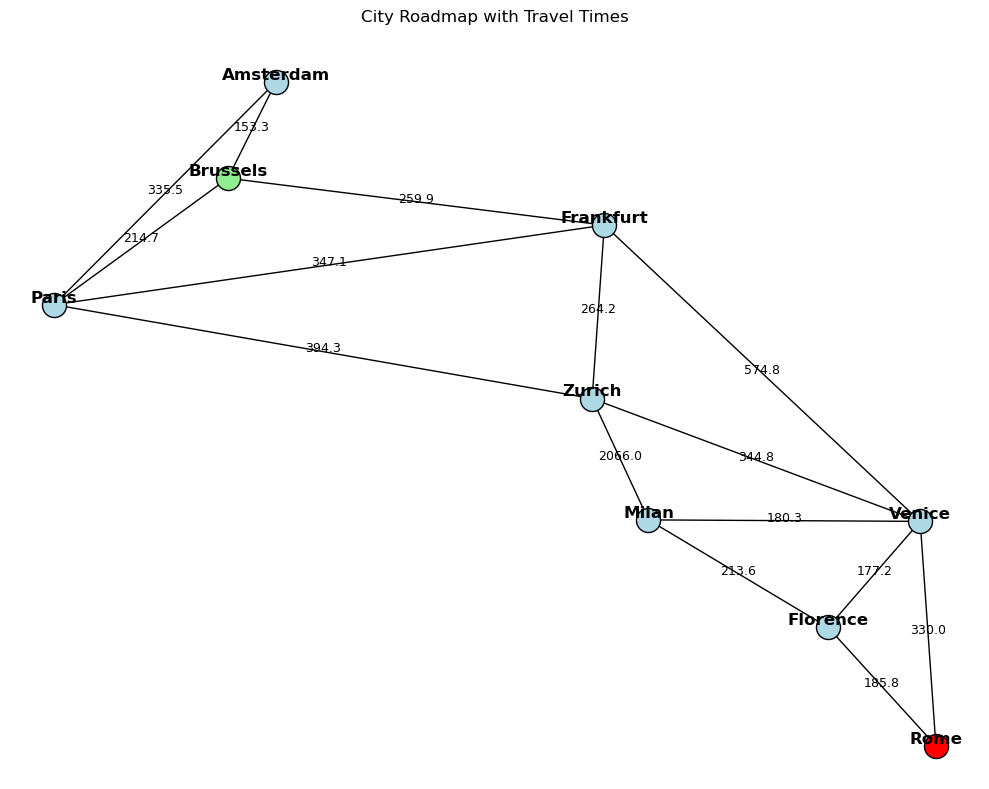

In [ ]:
base_case_with_uncertainty_graph, base_case_with_uncertainty_factor_dict = simulate_for_uncertainty(roadmap_graph, rush_hour=False)

print("The factor by which the time was increased was :")
print(base_case_with_uncertainty_factor_dict)

plot_graph_on_map(base_case_with_uncertainty_graph, start_location, end_location)


Shortest Path: ['Brussels', 'Frankfurt', 'Venice', 'Rome']
Total Cost: 1164.6999999999998


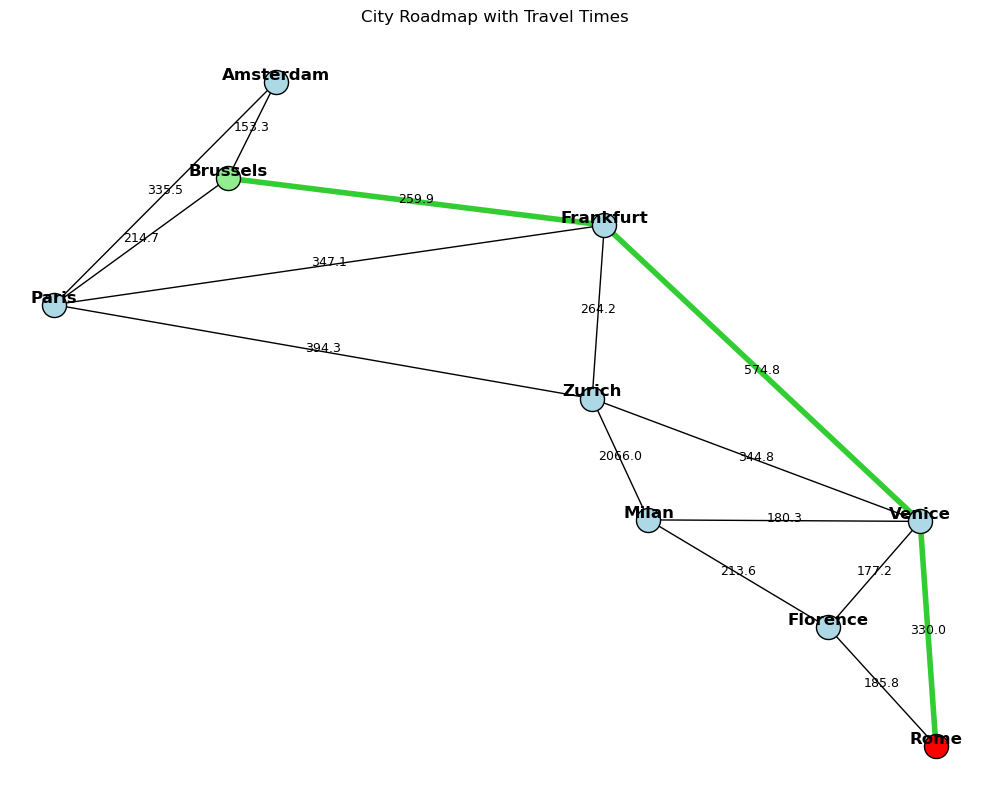

In [ ]:
# Find shortest path on rush hour with uncertainty graph
base_case_with_uncertaint_location_data, base_case_with_uncertaint_shortest_path = find_shortest_path(
    base_case_with_uncertainty_graph,
    start_location, end_location
)

print("Shortest Path:", base_case_with_uncertaint_shortest_path)
print("Total Cost:", base_case_with_uncertaint_location_data[end_location]["cost"])

plot_graph_on_map(
    base_case_with_uncertainty_graph,
    start_location, end_location,
    path=base_case_with_uncertaint_shortest_path
)


## Rush Hour With Uncertainity

The factor by which the time was increased was :
{('Paris', 'Zurich'): 2.6636208076550707, ('Brussels', 'Paris'): 2.364376444592853, ('Brussels', 'Frankfurt'): 1.888751961919193, ('Amsterdam', 'Paris'): 1.3215266331822284, ('Amsterdam', 'Brussels'): 1.7837578413195607, ('Frankfurt', 'Paris'): 2.284439793057486, ('Frankfurt', 'Zurich'): 1.2642290251278543, ('Frankfurt', 'Venice'): 2.7260190492398673, ('Milan', 'Zurich'): 1.3892871306025225, ('Milan', 'Venice'): 1.7499676799558481, ('Venice', 'Zurich'): 1.76018967304648, ('Florence', 'Milan'): 2.9789927225324604, ('Florence', 'Venice'): 2.084457015440331, ('Florence', 'Rome'): 2.726297354676934, ('Rome', 'Venice'): 1.8767313513453718, ('Milan', 'Florence'): 10.0}


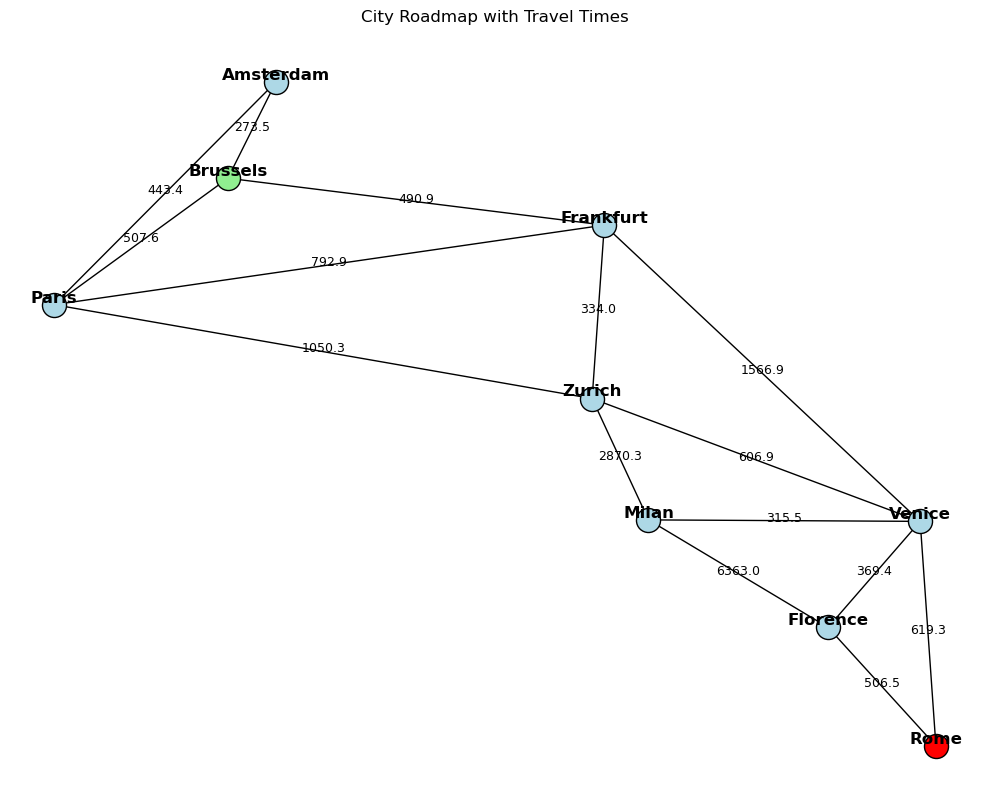

In [ ]:
rush_hour_with_uncertainty_graph, rush_hour_with_uncertainty_factor_dict = simulate_for_uncertainty(roadmap_graph, rush_hour=True)

print("The factor by which the time was increased was :")
print(rush_hour_with_uncertainty_factor_dict)

plot_graph_on_map(rush_hour_with_uncertainty_graph, start_location, end_location)


Shortest Path: ['Brussels', 'Frankfurt', 'Zurich', 'Venice', 'Rome']
Total Cost: 2051.1


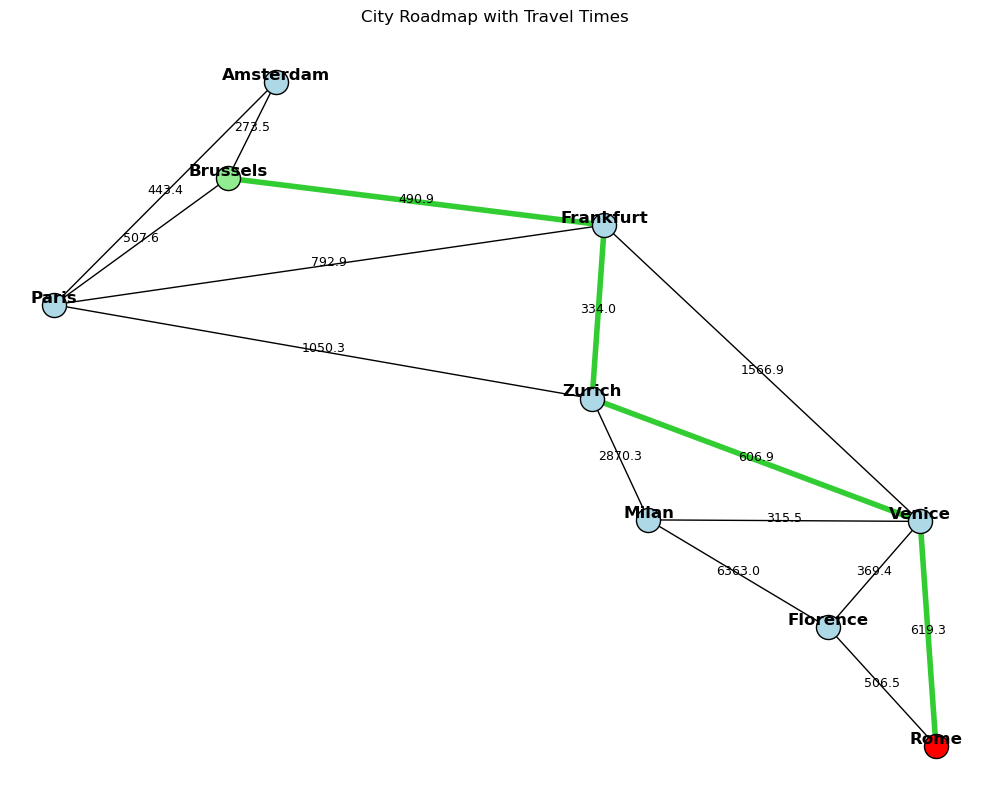

In [ ]:
# Find shortest path on rush hour with uncertainty graph
rush_hour_with_uncertaint_location_data, rush_hour_with_uncertaint_shortest_path = find_shortest_path(
    rush_hour_with_uncertainty_graph,
    start_location, end_location
)

print("Shortest Path:", rush_hour_with_uncertaint_shortest_path)
print("Total Cost:", rush_hour_with_uncertaint_location_data[end_location]["cost"])

# Plot the graph correctly
plot_graph_on_map(
    rush_hour_with_uncertainty_graph,
    start_location, end_location,
    path=rush_hour_with_uncertaint_shortest_path
)
